In [74]:
# Dependencies
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
import time

# Notations

In our implementations, 
- $N$ is the number of iterations
- $n$ is the number of observations $y = (y_1, ..., y_n)$. $y_i | \theta_i \sim F(\theta) = N(\theta, \tau)$ where $\tau$ is fixed. The prior on the $\theta_i$ is of the form $G_0 = N(0,1)$. 
- $\theta_i$ is the $F$-parameter of the observation $y_i$ 

When working with classes, we will use the following notations:
- $c_i$ is an integer representing class of observation $i$
- $\phi_c$ is the $F$-parameter of the class $c$
- $k$ is the number of classes


# Distribution functions

### General case

In [52]:
tau = 0.1
alpha = 0.5

In [53]:
# G0 is a normal distribution with mean 0 and variance 1
def g0_sampler():
    return np.random.normal(0, 1)

def g0_logdensity(theta):
    return -theta**2 / 2 - np.log(np.sqrt(2 * np.pi))

# f is a normal distribution with mean theta and variance tau
def f_sampler(theta):
    return np.random.normal(theta, tau)

# F(x, theta) evaluates F (normal distribution) in x
def F_likelihood(theta, x):
    return np.exp(-(theta - x)**2 / (2 * tau**2))

def F_loglikelihood(theta, x):
    return -(theta - x)**2 / (2 * tau**2)

Assume $x_i \mid \theta \sim \mathcal{N}\left(\theta, \tau^2\right)$ i.i.d.and $\theta \sim \mathcal{N}\left(\mu_0 = 0, \sigma^2 = 1\right)$. Then:
$$
\theta \mid x_{c1}, x_{c2}, \cdots, x_{|c|} \sim \mathcal{N}\left(\frac{\sigma^2}{\frac{\tau^2}{|c|}+\sigma^2} \overline{x_c}+\frac{\tau^2}{\frac{\tau^2}{|c|}+\sigma^2} \mu_0,\left(\frac{1}{\sigma^2}+\frac{|c|}{\tau^2}\right)^{-1}\right)
$$


$|c|$ is cardinal of the number of datapoints in class $c$

In [54]:
# Sample from the posterior distribution phi_c | G_0, F, {y_i s.t. c_i = c}
def posterior(y):
    mean = np.mean(y)
    number = len(y)
    return np.random.normal((1+ tau/number)*mean, 1/(1+ number/tau))

### Conjugate prior case (Algorithms 1, 2)

In [55]:
def Hi_sampler(y):
    m = (y / tau**2) / (1 / tau**2 + 1 / 1**2)
    s = 1 / (1 / tau**2 + 1 / 1**2)
    return np.random.normal(m, s)

def ri_integral(y):
    return tau * np.exp(-y**2 / (2 + 2 * tau**2)) / np.sqrt(tau**2 + 1)

### Dirichlet process

In [56]:
def DP_sampler(n):
    """
    Samples a vector theta (of size n) from a DP of parameter alpha
    and base distribution G0
    """
    # Sample the thetas
    thetas = []
    for i in range(n):
        u = np.random.uniform()
        if u < alpha / (alpha + i):
            thetas.append(g0_sampler())
        else:
            thetas.append(thetas[np.random.randint(0, i)])
    return thetas

In [57]:
def DP_loglikelihood(thetas):
    """
    Compute the loglikelihood of vector theta following a DP of parameter alpha and base distribution G0
    """
    lh = 0
    for i, theta in enumerate(thetas):
        if theta in thetas[:i]:
            lh += np.log(np.sum(np.equal(thetas[:i], theta)) / (i + alpha))
        else:
            lh += np.log(alpha / (i + alpha)) + g0_logdensity(theta)
    return lh

# Auxiliary functions

In [58]:
def find_unused_cluster(c):
    # Find the first unused cluster
    for k in range(len(c)):
        if np.sum(c == k) == 0:
            return k

    raise Exception("No unused cluster found")

def update_cluster_phis(c, phi, lh, y):
    """
    Update the cluster parameters phi from the datapoints belonging to the cluster
    by taking the mean of the datapoints
    """
    for c_unique in np.unique(c):
        phi[c_unique] = np.mean(y[c == c_unique])
        lh[c == c_unique] = F_loglikelihood(phi[c_unique], y[c == c_unique])


# Generate Data

In [59]:
def generate_data(n):
    thetas = DP_sampler(n)
    y = np.zeros(n)
    for i, theta in enumerate(thetas):
        y[i] = f_sampler(theta)
    return y, thetas

In [60]:
# Generate data
n = 60
y_data, thetas_data = generate_data(n)

Loglikelihood of original data: -57.25690492782595
Loglikelihood of thetas: -28.770594879605213
Loglikelihood of y | thetas: -28.486310048220737


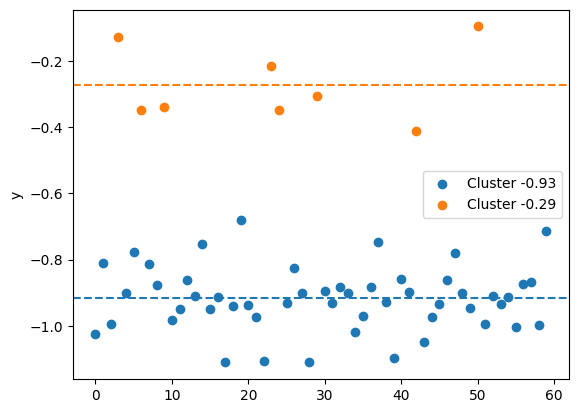

In [61]:
print(f"Loglikelihood of original data: {np.sum(F_loglikelihood(y_data, thetas_data)) + DP_loglikelihood(thetas_data)}")
print(f"Loglikelihood of thetas: {DP_loglikelihood(thetas_data)}")
print(f"Loglikelihood of y | thetas: {np.sum(F_loglikelihood(y_data, thetas_data))}")

# Plot data clusters
plt.figure()
COLORS = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
for c_unique in np.unique(thetas_data):
    color = next(COLORS)
    plt.scatter(np.arange(n)[thetas_data == c_unique], y_data[thetas_data == c_unique], c=color, label="Cluster {:.2f}".format(c_unique))
    plt.axhline(np.mean(y_data[thetas_data == c_unique]), c=color, linestyle='--')
plt.ylabel("y")
plt.legend()
plt.show()

In [62]:
# REFERENCE DATA FOR THE PAPER

# y_data = np.array([-0.3256188 , -0.43092995,  1.60089869,  1.80794025, -0.23496168,
#         2.22528021, -0.41624213, -0.2915612 , -0.52381541, -0.51177656,
#        -0.65748387,  1.58592953, -0.4750672 ,  1.74415777, -0.00440874,
#         1.47447673, -0.39477349, -0.41031549,  0.0649048 , -0.34165361,
#        -0.12707548,  1.57536289, -0.55966975, -0.3794802 ,  1.99659421,
#         2.12495612, -0.65394037,  1.5379578 , -0.23478165, -0.33167543,
#         1.47685422, -0.25004367,  1.78212218, -0.45731061,  1.38308488,
#         1.88843163,  1.50594422, -0.27256526, -0.71413434, -0.72292323,
#         1.89199991,  1.82468791, -0.31301438,  2.08910457,  2.04863437,
#         2.22805643,  1.6256737 , -0.11244296,  1.74405149,  1.63885817,
#        -0.18896373,  2.02685373, -0.67696542,  1.90177644, -0.22765228,
#        -0.49304382,  1.84345641,  1.78513511,  1.787267  ,  1.83192619,
#        -0.30702378,  1.926645  ,  2.02899633, -0.443003  , -0.61737759,
#        -0.27819684, -0.34121134, -0.79604005,  1.75253447,  1.56055199,
#        -0.28329314,  2.0233593 , -0.50098222,  1.67228192, -0.18476536,
#        -0.55037805, -0.374823  , -0.34098955,  1.84975783,  1.77908043,
#         1.87272933,  2.22590325, -0.5551349 , -0.57476731, -0.17715395,
#        -0.39921745,  1.55985138,  1.88851503,  1.71074307,  1.87987111,
#         2.01673192, -0.55740399,  1.86515774,  1.75052161,  1.77981471,
#        -0.33884651, -0.36026426,  1.60227771,  1.96343786, -0.61051141])
# thetas_data = [0.14699579158972725, 0.14699579158972725, 0.14699579158972725, -1.3588678536328178, 0.14699579158972725, -1.3588678536328178, 0.14699579158972725, 0.14699579158972725, 0.14699579158972725,
#                -1.3588678536328178, 0.14699579158972725, 1.1342362159812744, -0.6611446765066387, -1.6146995480063322, 0.14699579158972725, -1.6146995480063322, 0.14699579158972725, 0.14699579158972725,
#                0.14699579158972725, 0.14699579158972725, -1.3588678536328178, 0.14699579158972725, -0.6611446765066387, -1.3588678536328178, 0.14699579158972725, -0.6611446765066387, 0.14699579158972725,
#                0.14699579158972725, 0.14699579158972725, 0.14699579158972725, -1.6146995480063322, -1.3588678536328178, -0.6611446765066387, -1.6146995480063322, 0.14699579158972725, -1.3588678536328178,
#                0.14699579158972725, 0.14699579158972725, 0.14699579158972725, 0.14699579158972725, -1.3588678536328178, -1.3588678536328178, -1.3588678536328178, 0.14699579158972725, 0.14699579158972725,
#                0.14699579158972725, -0.6611446765066387, -1.3588678536328178, 0.14699579158972725, -1.3588678536328178, -0.6611446765066387, 0.14699579158972725, 0.14699579158972725, -1.3588678536328178,
#                -0.6611446765066387, -0.6611446765066387, 0.14699579158972725, -1.3588678536328178, -1.3588678536328178, 0.14699579158972725]

# Util functions to run algorithms, compute metrics and plot results

In [63]:
def to_cs_phis(thetas):
    """
    Convert thetas to cs and phis
    """
    phis = np.zeros_like(thetas, dtype=float)
    cs = np.zeros_like(thetas, dtype=int)
    for i, theta in enumerate(thetas):
        for c_unique, theta_unique in enumerate(np.unique(theta)):
            cs[i, theta == theta_unique] = c_unique
            phis[i, c_unique] = theta_unique
    return cs, phis

In [64]:
def autocorr(x):
    """"
    Compute the autocorrelation of a multivariate time series
    """
    ac = np.zeros_like(x)
    x_centered = x - np.mean(x, axis=0)
    for i in range(x.shape[1]):
        ac[:, i] = np.correlate(x_centered[:, i], x_centered[:, i], mode='full')[x.shape[0]-1:]
    return ac

In [65]:
def rand_index(c_target, c):
    """
    Compute the rand index between two cluster assignments
    """
    n = len(c_target)
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for i in range(n):
        for j in range(i+1, n):
            if c_target[i] == c_target[j] and c[i] == c[j]:
                tp += 1
            elif c_target[i] != c_target[j] and c[i] != c[j]:
                tn += 1
            elif c_target[i] == c_target[j] and c[i] != c[j]:
                fp += 1
            elif c_target[i] != c_target[j] and c[i] == c[j]:
                fn += 1
    return (tp + tn) / (tp + tn + fp + fn)

In [66]:
def run_algorithm(algorithm, N, y):
    """
    Run algorithm and plot evolution of log_likelihood, theta and cluster assignments
    """
    # Run algorithm
    start_time =  time.time()
    cs, phis = algorithm(N, y)
    end_time = time.time()

    print(f"Time per interation: {(end_time - start_time) / N:.6f} seconds")

    complete_llhs = np.zeros((N+1), dtype=float)
    for i in range(N+1):
        complete_llhs[i] = F_loglikelihood(phis[i, cs[i]], y).sum() + DP_loglikelihood(phis[i, cs[i]])

    # Compute autocorrelation time of number of distinct clusters
    ks = np.zeros((N+1), dtype=int)
    for i in range(N+1):
        ks[i] = len(np.unique(cs[i]))

    ac = autocorr(ks.reshape(-1, 1))
    ac = ac / ac[0]
    # ac_time_limit is the first time the autocorrelation is below 0.05
    ac_time_limit = np.argmax(ac < 0.05)
    ac_time = 1 + 2 * np.sum(ac[:ac_time_limit])
    print(f"Autocorrelation time: {ac_time:.2f}")


    # define infinite list of colors
    COLORS = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
    for i, cluster in enumerate(np.unique(cs[-1])):
        if np.sum(cs[-1] == cluster) == 1:
            plt.scatter(np.arange(n)[cs[-1] == cluster], y[cs[-1] == cluster], color="black")
        else:
            color = next(COLORS)
            plt.scatter(np.arange(n)[cs[-1] == cluster], y[cs[-1] == cluster], label=i, color=color)
            plt.axhline(phis[-1, cluster], color=color, linestyle="--")
    plt.title("Generated data")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

    # Plot evolution of log likelihood
    plt.figure()
    # Plot horizontal line for best log likelihood
    plt.axhline(np.max(complete_llhs), color="red", linestyle="--", label="Best log likelihood : {:.2f}".format(np.max(complete_llhs)))
    plt.plot(np.arange(N+1), complete_llhs)

    plt.title("Log likelihood")
    plt.xlabel("Iteration")
    plt.ylabel("Log likelihood")
    plt.legend()
    plt.show()

    # plot evolution of theta
    plt.figure()
    it_list = []
    phi_list = []
    size_list = []
    for it in range(0, N+1):
        phis_counts = np.unique(phis[it, cs[it]], return_counts=True)
        phi_list.extend(phis_counts[0])
        it_list.extend([it] * len(phis_counts[0]))
        size_list.extend(phis_counts[1])

    plt.scatter(it_list, phi_list, s= 100 * np.square(np.array(size_list, dtype=float) / np.max(size_list)), c=size_list)
    plt.xlabel("Iteration")
    plt.ylabel("Cluster mean")
    plt.colorbar(label = "Cluster size")
    plt.show()


    plt.plot(ac)
    plt.title("Autocorrelation of number of clusters")
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    # Plot ac_time_limit
    plt.axvline(ac_time_limit, color="red", linestyle="--")
    plt.show()


In [77]:
def run_algorithm_multiple(algorithm, N, R):
    """
    Run algorithm R times and print metrics
    """
    # Run algorithm
    cs_list = []
    phis_list = []
    y_list = [y_data for _ in range(R)]
    start_time =  time.time()
    for y in y_list:
        cs, phis = algorithm(N, y)
        cs_list.append(cs)
        phis_list.append(phis)
    end_time = time.time()

    print(f"Total time: {(end_time - start_time):.6f} seconds")
    print(f"Time per interation: {(end_time - start_time) / (R*N):.6f} seconds")

    complete_llhs = np.zeros((R, N+1), dtype=float)
    for r in range(R):
        for i in range(N+1):
            complete_llhs[r, i] = F_loglikelihood(phis_list[r][i, cs_list[r][i]], y_list[r]).sum() + DP_loglikelihood(phis_list[r][i, cs_list[r][i]])

    # ------------------------------ #
    # Final log likelihood and best log likelihood

    final_llhs = [llh[-1] for llh in complete_llhs]
    best_llhs = [np.max(llh) for llh in complete_llhs]

    print(f"Final log likelihood : mean : {np.mean(final_llhs):.2f}, std : {np.std(final_llhs):.2f}")
    print(f"Best log likelihood : mean : {np.mean(best_llhs):.2f}, std : {np.std(best_llhs):.2f}")
    print(f"Best log likelihood (out of the best run) : {np.max(best_llhs):.2f}")


    # ------------------------------ #
    # Rand index

    # Compute rand index between thetas and thetas_list
    rand_indices = []
    for r in range(R):
        rand_indices.append(rand_index(thetas_data, phis_list[r][-1, cs_list[r][-1]]))

    print(f"Rand index : mean : {np.mean(rand_indices):.2f}, std : {np.std(rand_indices):.2f}")


    # ------------------------------ #
    # Autocorrelation time - number of clusters

    # Compute autocorrelation time of number of distinct clusters
    ks = np.zeros((R, N+1), dtype=int)
    for r in range(R):
        for i in range(N+1):
            ks[r, i] = len(np.unique(cs_list[r][i]))

    ac = autocorr(ks.T)
    ac = ac / ac[0]
    # ac_time_limit is the first time the autocorrelation is below 0.05
    ac_time_limit = np.argmax(ac < 0.05, axis=0)
    ac_times = []
    for r in range(R):
        ac_times.append(1 + 2 * np.sum(ac[1:ac_time_limit[r], r]))
    print(f"ACT n clusters : mean : {np.mean(ac_times):.2f}, std : {np.std(ac_times):.2f}")

    # ------------------------------ #
    # Autocorrelation time - phi[c]

    ac = autocorr(np.concatenate([np.array([
        phis_list[r][i, cs_list[r][i]]
        for i in range(N+1)
    ]).T for r in range(R)]).T)
    ac = ac / ac[0]
    # ac_time_limit is the first time the autocorrelation is below 0.05
    ac_time_limit = np.argmax(ac < 0.05, axis=0)
    ac_times_2 = []
    for r in range(R):
        ac_time_avg = []
        for i in range(n):
            ac_time_avg.append(1 + 2 * np.sum(ac[1:ac_time_limit[r*n + i], r*n + i]))
        ac_times_2.append(np.mean(ac_time_avg))

    print(f"ACT thetas : mean : {np.mean(ac_times_2):.2f}, std : {np.std(ac_times_2):.2f}")

    # # ------------------------------ #
    # # print latex table
    # print(
    #     f"{1000*(end_time - start_time) / (R*N):3.1f} & {np.mean(final_llhs):6.1f} \\pm {np.std(final_llhs):3.1f} & {np.mean(ac_times):6.1f} \\pm {np.std(ac_times):3.1f} & {np.mean(ac_times_2):6.1f} \\pm {np.std(ac_times_2):3.1f} &  {np.mean(rand_indices):.2f} \pm {np.std(rand_indices):.2f} \\\\",
    #     file = open("table.txt", "a")
    # )

    print("-----------------------------")


# Define Algorithms

### Algorithm 1

In [68]:
def algorithm_1(N, y):
    # Initialize
    n = len(y)
    thetas = np.zeros((N+1, n), dtype=float)
    thetas[0] = y.copy()

    # Loop over data
    for i in range(1, N+1):
        theta = thetas[i-1].copy()

        # Perform Gibbs sampling
        for j in range(n):
            lh_proposals = np.zeros(n, dtype=float)
            for theta_unique in np.unique(theta):
                lh_proposals[theta == theta_unique] = F_likelihood(theta_unique, y[j])
            lh_proposals[j] = alpha * ri_integral(y[j])

            # Sample j
            j_proposal = np.random.choice(n, p=lh_proposals / np.sum(lh_proposals))
            if j_proposal == j:
                theta[j] = Hi_sampler(y[j])
            else:
                theta[j] = theta[j_proposal]

        thetas[i] = theta

    return thetas

## Algorithm 2

In [69]:
def algorithm_2(n_iters, y):
    n = len(y)
    phis = np.zeros((n_iters+1, n), dtype=float)
    cs = np.zeros((n_iters+1, n), dtype=int)
    cs[0] = np.arange(n)
    phis[0] = y.copy()

    for iter in range(1, n_iters+1):
        phi = phis[iter-1].copy() 
        c = cs[iter-1].copy()

        for ii in range(n):
            c_unique, c_count = np.unique(c, return_counts=True)
            # get n_-i,c
            c_count -= (c_unique == c[ii]).astype(int)

            
            # Remove phi_ci from the state and draw a new value for ci from eq 3.6
            new_parameter_prob = alpha / (n - 1 + alpha) * ri_integral(y[ii])
            old_parameter_prob = 1 / (n - 1 + alpha) * F_likelihood(phi[c_unique], y[ii])
            # Sampling probabilities for all [old params , new param] 
            sampling_prob = np.append(old_parameter_prob * c_count , new_parameter_prob)
            # Normalize to get a probability distribution
            sampling_prob /= np.sum(sampling_prob)
            # Choose cluster with probability sampling_prob
            # The new cluster replaces an unused cluster
            if np.sum(c == c[ii]) == 1:
                ci_star = np.random.choice(np.append(c_unique, c[ii]), p=sampling_prob)
            else:
                ci_star = np.random.choice(np.append(c_unique, find_unused_cluster(c)), p=sampling_prob)
            c[ii] = ci_star
            if np.sum(ci_star == c) == 1:
                phi[ci_star] = Hi_sampler(y[c == ci_star])
            
        
        for c_unique in np.unique(c):
            phi[c_unique] = posterior(y[c == c_unique])
    
        cs[iter] = c.copy()
        phis[iter] = phi.copy()

    return cs, phis


## Algorithm 4

In [70]:
def algorithm_4(N, y):
    n = len(y)
    cs = np.zeros((N+1, n), dtype=int)
    phis = np.zeros((N+1, n), dtype=float)
    lhs = np.zeros((N+1, n), dtype=float)
    lhs[0] = np.array([F_likelihood(phis[0, j], y[j]) for j in range(len(y))])
    # Initialization exception : all points are in the same cluster of mean = empirical_mean(y)

    phis[0] = np.full(n,np.mean(y))

    for i in range(1, N+1):
        c = cs[i-1].copy()
        phi = phis[i-1].copy()
        lh = lhs[i-1].copy()

        for j in range(n):
            k = len(np.unique(c[np.arange(n) != j]))
            c_proposal = find_unused_cluster(c)

            if np.sum(c == c[j]) == 1:
                if np.random.uniform() < 1 / (k + 1):
                    c[j] = c_proposal
                    phi[c[j]] = g0_sampler()
            
            else:
                phi_proposal = g0_sampler()
                lh_proposals = np.zeros(n)
                for c_unique in np.unique(c):
                    lh_proposals[c == c_unique] = F_likelihood(phi[c_unique], y[j])

                lh_proposals[j] = (alpha / (k + 1)) * F_likelihood(phi_proposal, y[j]) 

                j_proposal = np.random.choice(n, p=lh_proposals / np.sum(lh_proposals))

                if j_proposal == j:
                    c[j] = c_proposal
                    phi[c[j]] = phi_proposal
                    lh[j] = lh_proposals[j_proposal] * ((k + 1) / alpha)
                else:
                    c[j] = c[j_proposal]
                    lh[j] = lh_proposals[j_proposal]

        update_cluster_phis(c, phi, lh, y)
            
        cs[i] = c
        phis[i] = phi
        lhs[i] = lh

    return cs, phis

## Algorithm 5

In [71]:
def algorithm_5_sampler(c_unique, c_count, c, n):
        # Draw a candidate phi_i_star from Eq 5.4
        new_parameter_prob = alpha / (n - 1 + alpha)
        old_parameter_prob = 1 / (n - 1 + alpha)
        # Sampling probabilities for all [old params , new param] and normalize to get a probability distribution
        sampling_prob = np.append(old_parameter_prob * c_count , new_parameter_prob)
        sampling_prob /= np.sum(sampling_prob)
        # Choose cluster with probability sampling_prob
        # The new cluster replaces an unused cluster
        ci_star = np.random.choice(np.append(c_unique, find_unused_cluster(c)), p=sampling_prob)
        return ci_star

def algorithm_5(n_iters, y):
    n = len(y)
    cs = np.zeros((n_iters+1, n), dtype=int)
    phis = np.zeros((n_iters+1, n), dtype=float)
    lhs = np.zeros((n_iters+1, n), dtype=float)
    # Initialization exception : all points are in the same cluster of mean = empirical_mean(y)
    phis[0] = np.full(n,np.mean(y))


    for iter in range(1,n_iters+1):
        c = cs[iter-1].copy()
        phi = phis[iter-1].copy()
        lh = lhs[iter-1].copy()

        for ii in range(n):
            c_unique, c_count = np.unique(c, return_counts=True)
            # get n_-i,c
            c_count -= (c_unique == c[ii]).astype(int)
            # Sample a ci_star from Eq 5.4
            ci_star = algorithm_5_sampler(c_unique, c_count, c, n)

            # If the sampled index is the last one, we sample from G0
            if ci_star == len(c_unique):
                phi_proposal = g0_sampler()
            else: # Else we use an existing cluster
                phi_proposal = phi[ci_star]
            
            lh_proposal = F_likelihood(phi_proposal, y[ii])

            # Compute acceptance probability
            acceptance_prob = min(1, lh_proposal / lh[ii])

            # Accept or reject
            if np.random.rand() < acceptance_prob:
                c[ii] = ci_star
                phi[c[ii]] = phi_proposal
                lh[ii] = lh_proposal
        


        for c_unique in np.unique(c):
            phi[c_unique] = np.mean(y[c == c_unique])

        cs[iter] = c.copy()
        phis[iter] = phi.copy()
        lhs[iter] = lh.copy()

    return cs, phis

## Algorithm 6

In [72]:
def algorithm_6_sample(theta):
    # Choose wether we sample from existing theta or from g0
    if np.random.rand() < alpha / (len(theta) + alpha):
        # Sample from g0
        theta = g0_sampler()
    else:
        # Sample from existing theta
        theta = np.random.choice(theta)

    return theta

def algorithm_6(N, y):
    n = len(y)
    thetas = np.zeros((N+1, n))
    lhs = np.zeros((N+1, n))
    lhs[0] = np.array([F_likelihood(thetas[0, j], y[j]) for j in range(n)])
    thetas[0] = y.copy()

    for i in range(1, N+1):
        theta = thetas[i-1].copy()
        lh = lhs[i-1].copy()
        for j in range(n):
            theta_proposal = algorithm_6_sample(theta[np.arange(n) != j])
            lh_proposal = F_likelihood(theta_proposal, y[j])

            # Compute acceptance probability
            a = min(1, lh_proposal / lh[j])

            # Accept or reject
            if np.random.rand() < a:
                theta[j] = theta_proposal
                lh[j] = lh_proposal
            
        thetas[i] = theta
        lhs[i] = lh

    return thetas


## Algorithm 7

In [73]:
def algorithm_7(N, y):
    n = len(y)
    cs = np.zeros((N+1, n), dtype=int)
    phis = np.zeros((N+1, n), dtype=float)
    lhs = np.zeros((N+1, n), dtype=float)
    lhs[0] = np.array([F_likelihood(phis[0, j], y[j]) for j in range(len(y))])
    cs[0] = np.arange(n)
    phis[0] = y.copy()

    for i in range(1, N+1):
        c = cs[i-1].copy()
        phi = phis[i-1].copy()
        lh = lhs[i-1].copy()

        for j in range(n):
            # test if c[j] is a singleton
            if np.sum(c == c[j]) == 1:
                # Choose c[j] from c[-j] with probability n_i / (n - 1)
                c_proposal = np.random.choice(c[c != c[j]])
                lh_proposal = F_likelihood(phi[c_proposal], y[j])

                # Compute acceptance probability
                a = min(1, ((n-1) / alpha) * lh_proposal / lh[j])

                # Accept or reject
                if np.random.rand() < a:
                    c[j] = c_proposal
                    phi[c[j]] = phi[c_proposal]
                    lh[j] = lh_proposal

            else:
                c_proposal = find_unused_cluster(c)
                phi_proposal = g0_sampler()
                lh_proposal = F_likelihood(phi_proposal, y[j])

                # Compute acceptance probability
                a = min(1, (alpha / (n - 1)) * lh_proposal / lh[j])

                # Accept or reject
                if np.random.rand() < a:
                    c[j] = c_proposal
                    phi[c[j]] = phi_proposal
                    lh[j] = lh_proposal

        for j in range(n):
            # test if c[j] is not a singleton
            if np.sum(c == c[j]) > 1:

                # Compute transition probas
                lh_proposals = np.zeros(n, dtype=float)
                for c_unique in np.unique(c):
                    lh_proposals[c == c_unique] = F_likelihood(phi[c_unique], y[j])
                lh_proposals[j] = 0

                j_proposal = np.random.choice(n, p=lh_proposals / np.sum(lh_proposals))
                c[j] = c[j_proposal]
                lh[j] = lh_proposals[j_proposal]

        update_cluster_phis(c, phi, lh, y)  

        cs[i] = c
        phis[i] = phi
        lhs[i] = lh

    return cs, phis

## Algorithm 8

In [74]:
def algorithm_8(y, N, m):
    n = len(y)
    phi_table = np.zeros((N+1, n + m), dtype=float)
    c_table = np.zeros((N+1, n), dtype=int)
    c_table[0] = np.array([i + 1 for i in range(n)])
    phi_table[0, :n] = y.copy()
    c_table[0] = np.arange(n) 

    for loop in range(N):
        c = c_table[loop].copy()
        phi = phi_table[loop].copy()
        for i in range(n):
            c_minus_i = np.concatenate((c[:i], c[i + 1:]))
            k_ = np.unique(c_minus_i).size
            if c[i] in c_minus_i:
                phi[-m:] = np.array([g0_sampler() for _ in range(m)])
            else:
                phi[-m + 1:] = np.array([g0_sampler() for _ in range(m - 1)])
            probabilities = []
            for cluster in range(1, n + m + 1):
                if cluster <= n:
                    n_occurence = np.sum(c_minus_i == cluster)
                    probabilities.append(n_occurence / (n - 1 + alpha) * F_likelihood(phi[cluster - 1], y[i]))
                else:
                    probabilities.append((alpha / m) / (n - 1 + alpha) * F_likelihood(phi[cluster - 1], y[i])) 
            probabilities = np.array(probabilities)
            probabilities_without_nan = np.nan_to_num(probabilities, nan=0)
            sum_prob_without_nan = np.sum(probabilities_without_nan)
            if sum_prob_without_nan == 0:
                c[i] = np.random.choice(np.array([i + 1 for i in range(n + m)]))
            else:
                probabilities /= sum_prob_without_nan
                c[i] = np.random.choice(np.array([i + 1 for i in range(n + m)]), p=probabilities)
        for cluster in np.unique(c):
            phi[cluster - 1] = np.mean(y[c == cluster])
        phi_table[loop + 1] = phi
        c_table[loop + 1] = c

    return c_table - 1, phi_table

# Run benchmark

In [78]:
print("Algorithm 1")
run_algorithm_multiple(lambda N, y: to_cs_phis(algorithm_1(N, y)), 200, 20)
print("Algorithm 2")
run_algorithm_multiple(lambda N, y: algorithm_2(N, y), 200, 20)
print("Algorithm 4")
run_algorithm_multiple(lambda N, y: algorithm_4(N, y), 200, 20)
print("Algorithm 5")
run_algorithm_multiple(lambda N, y: algorithm_5(N, y), 200, 20)
print("Algorithm 6")
run_algorithm_multiple(lambda N, y: to_cs_phis(algorithm_6(N, y)), 200, 20)
print("Algorithm 7")
run_algorithm_multiple(lambda N, y: algorithm_7(N, y), 200, 20)
print("Algorithm 8")
run_algorithm_multiple(lambda N, y: algorithm_8(y, N, 10), 200, 20)

Algorithm 1
Total time: 24.983601 seconds
Time per interation: 0.006246 seconds
Final log likelihood : mean : -73.67, std : 16.00
Best log likelihood : mean : -63.73, std : 8.67
Best log likelihood (out of the best run) : -57.04
Rand index : mean : 0.86, std : 0.16
(201, 20)
ACT n clusters : mean : 10.05, std : 8.00
(201, 1200)
ACT thetas : mean : 3.77, std : 3.34
-----------------------------
Algorithm 2


C:\Users\Marius\AppData\Local\Temp\ipykernel_22880\1125488719.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  phi[ci_star] = Hi_sampler(y[c == ci_star])


Total time: 43.268932 seconds
Time per interation: 0.010817 seconds
Final log likelihood : mean : -60.37, std : 7.86
Best log likelihood : mean : -56.71, std : 0.00
Best log likelihood (out of the best run) : -56.70
Rand index : mean : 0.97, std : 0.08
(201, 20)
ACT n clusters : mean : 5.07, std : 2.94
(201, 1200)
ACT thetas : mean : 1.12, std : 0.11
-----------------------------
Algorithm 4
Total time: 45.059695 seconds
Time per interation: 0.011265 seconds
Final log likelihood : mean : -107.35, std : 18.08
Best log likelihood : mean : -62.33, std : 4.69
Best log likelihood (out of the best run) : -56.70
Rand index : mean : 0.67, std : 0.14
(201, 20)
ACT n clusters : mean : 52.04, std : 16.28
(201, 1200)
ACT thetas : mean : 1.45, std : 0.26
-----------------------------
Algorithm 5


C:\Users\Marius\AppData\Local\Temp\ipykernel_22880\976178508.py:40: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Total time: 33.291035 seconds
Time per interation: 0.008323 seconds
Final log likelihood : mean : -70.44, std : 26.67
Best log likelihood : mean : -58.93, std : 6.66
Best log likelihood (out of the best run) : -56.70
Rand index : mean : 0.97, std : 0.05
(201, 20)
ACT n clusters : mean : 25.05, std : 15.52
(201, 1200)
ACT thetas : mean : 14.54, std : 7.10
-----------------------------
Algorithm 6
Total time: 7.683977 seconds
Time per interation: 0.001921 seconds
Final log likelihood : mean : -82.77, std : 20.40
Best log likelihood : mean : -76.00, std : 12.45
Best log likelihood (out of the best run) : -58.38
Rand index : mean : 0.90, std : 0.16
(201, 20)
ACT n clusters : mean : 23.69, std : 9.76
(201, 1200)
ACT thetas : mean : 19.40, std : 8.67
-----------------------------
Algorithm 7


C:\Users\Marius\AppData\Local\Temp\ipykernel_22880\3516862913.py:73: RuntimeWarning: invalid value encountered in divide
  ac = ac / ac[0]
C:\Users\Marius\AppData\Local\Temp\ipykernel_22880\4180949298.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  a = min(1, ((n-1) / alpha) * lh_proposal / lh[j])


Total time: 95.430859 seconds
Time per interation: 0.023858 seconds
Final log likelihood : mean : -208.87, std : 18.95
Best log likelihood : mean : -184.30, std : 25.50
Best log likelihood (out of the best run) : -128.88
Rand index : mean : 0.31, std : 0.03
(201, 20)
ACT n clusters : mean : 1.00, std : 0.00
(201, 1200)
ACT thetas : mean : 1.23, std : 0.05
-----------------------------
Algorithm 8
Total time: 265.009709 seconds
Time per interation: 0.066252 seconds
Final log likelihood : mean : -58.21, std : 3.66
Best log likelihood : mean : -57.07, std : 1.61
Best log likelihood (out of the best run) : -56.70
Rand index : mean : 0.99, std : 0.01
(201, 20)
ACT n clusters : mean : 1.99, std : 0.27
(201, 1200)
ACT thetas : mean : 1.11, std : 0.05
-----------------------------
